In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os

In [ ]:
os.chdir("/content/drive/MyDrive/BE 177A Capstone - Team C/Code/RewrittenCode")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/BE 177A Capstone - Team C/Code/RewrittenCode'

In [ ]:
!ls

'Copy of model.py'  'Copy of new_dataloader.py'  'Copy of test.ipynb'  'Copy of unet_blocks.py'


In [ ]:
!pip install pydicom
import pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 7.3 MB/s eta 0:00:00


In [ ]:
from new_dataloader import MRIDataset
from torch.utils.data import DataLoader, random_split

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import glob
patients = glob.glob('/content/drive/MyDrive/Capstone/Data/knee_MRI_dataset/MTR*')
print(len(patients))

155


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float())
])

target_transform = transforms.Compose([
    transforms.Lambda(lambda arr: arr != 0), # create binary mask
    transforms.Lambda(lambda arr: torch.tensor(arr, dtype=torch.float32))
])

In [ ]:
# dataset and loader (only 2 patients)
dataset = MRIDataset('/content/drive/MyDrive/Capstone/Data/knee_MRI_dataset', '/content/drive/MyDrive/Capstone/Data/knee_MRI_dataset/segmentation_mask', transform=transform, target_transform=target_transform)
total_size = len(dataset)
train_size = int(total_size * 0.8)
val_size = int(total_size * 0.1)
test_size = total_size - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

device = torch.device('cuda')

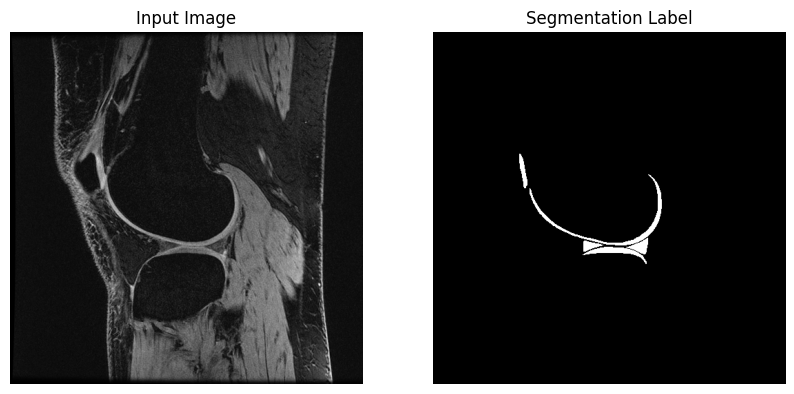

In [ ]:
# For visualization purposes
def trial():
    for image, label in train_loader:
        image_np = image.cpu().detach().numpy().squeeze()
        label_np = label.cpu().detach().numpy().squeeze()
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(image_np, cmap='gray')
        axes[0].set_title("Input Image")
        axes[0].axis('off')

        # Display the segmentation label
        axes[1].imshow(label_np, cmap='gray')
        axes[1].set_title("Segmentation Label")
        axes[1].axis('off')

        plt.show()
        break
trial()


In [ ]:
class DiceLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.smooth = 1e-06

  def forward(self, input, target):
    # Flatten Tensors
    input = input.view(input.shape[0], -1)
    target = target.view(target.shape[0], -1)

    # Calculate intersection and dice coefficient
    intersection = (input * target).sum()+self.smooth
    dice_coefficient = (2. * intersection) / (input.sum() + target.sum() + self.smooth)

    return 1-dice_coefficient.mean()

In [ ]:
from model import UNet

# Initialize network and move it to GPU
network = UNet(1, 1)
network.cuda()

# Loss function
diceloss = DiceLoss()

# Optimizer
lr_rate = 0.01
optimizer = optim.Adam(network.parameters(), lr=lr_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [ ]:
training_loss = []
validation_loss = []


num_epochs = 10
for epoch in range(num_epochs):
  network.train() # set to training mode
  running_loss = 0

  for inputs, labels in train_loader:
    # moving to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero out gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = network(inputs)
    loss = diceloss(outputs, labels)

    # Backward pass
    loss.backward()

    # Update Step
    optimizer.step()

    # Update running loss
    running_loss += loss

  avg_train_loss = running_loss / len(train_loader)
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss.item():.4f}')

  # Validate the model after each epoch
  network.eval()  # Set the model to evaluation mode
  val_loss = 0.0
  with torch.no_grad():
      for val_images, val_labels in val_loader:
          val_images, val_labels = val_images.to(device), val_labels.to(device)
          val_outputs = network(val_images)
          val_loss += diceloss(val_outputs, val_labels).item()

  avg_val_loss = val_loss / len(val_loader)
  print(f'Validation Loss: {avg_val_loss:.4f}')

  training_loss.append(avg_train_loss.item())
  validation_loss.append(avg_val_loss)


Epoch [1/10], Loss: 0.9429
Validation Loss: 0.9574


In [ ]:
for images, labels in train_loader:
    print(images.dtype)  # Should output torch.float32
    print(labels.dtype)  # Should output torch.float32 or the appropriate dtype for your task
    break  # Just check one batch

torch.int16
torch.float32


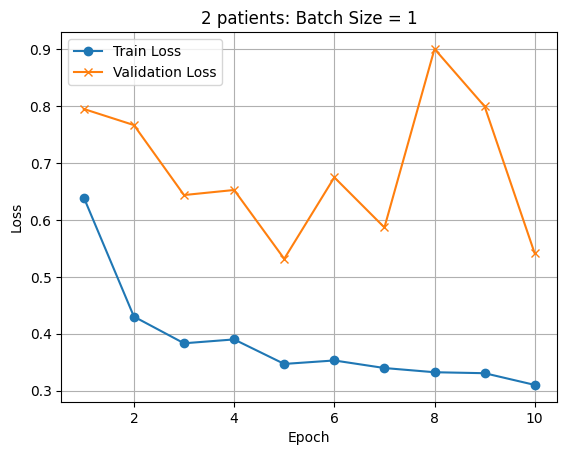

In [ ]:
# Given data
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_loss = [0.6393, 0.4300, 0.3831, 0.3899, 0.3468, 0.3529, 0.3396, 0.3322, 0.3305, 0.3099]
val_loss = [0.7950, 0.7667, 0.6437, 0.6526, 0.5316, 0.6748, 0.5867, 0.9006, 0.7995, 0.5410]

# Plotting the loss data
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('2 patients: Batch Size = 1')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


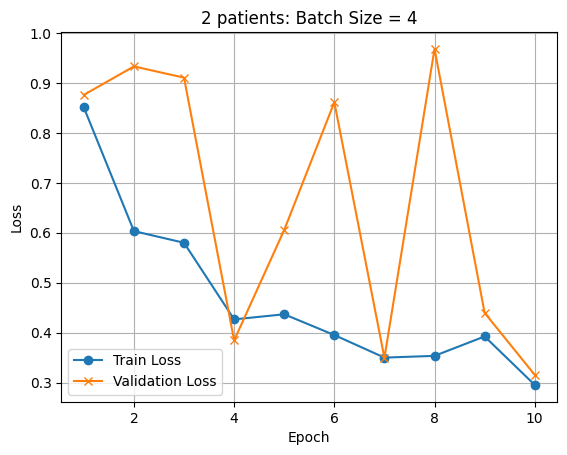

In [ ]:
train_loss = [0.8510, 0.6033, 0.5799, 0.4265, 0.4367, 0.3951, 0.3499, 0.3534, 0.3923, 0.2952]
val_loss = [0.8761, 0.9332, 0.9106, 0.3844, 0.6056, 0.8614, 0.3494, 0.9682, 0.4395, 0.3154]

# Plotting the loss data
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('2 patients: Batch Size = 4')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

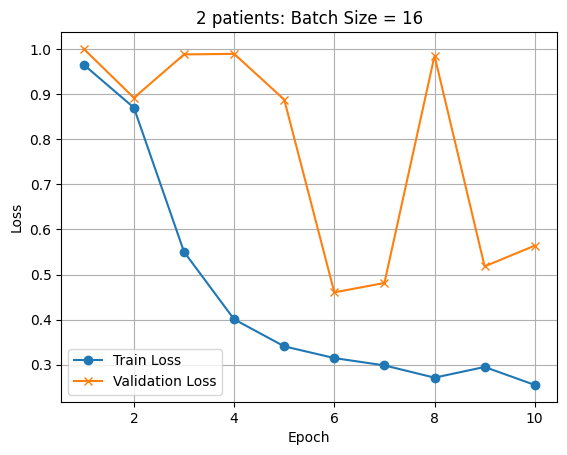

In [ ]:
train_loss = [0.9649, 0.8697, 0.5503, 0.4007, 0.3408, 0.3148, 0.2986, 0.2714, 0.2951, 0.2553]
val_loss = [1.0000, 0.8916, 0.9878, 0.9891, 0.8877, 0.4604, 0.4813, 0.9848, 0.5180, 0.5640]

# Plotting the loss data
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('2 patients: Batch Size = 16')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()